<a href="https://colab.research.google.com/github/charaannn/NLP-PROGRAMMING/blob/main/snapsort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install transformers

In [12]:
import numpy as np
import pandas as pd

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
#Instead of importing AdamW from transformers, import it from torch.optim
from torch.optim import AdamW
# Import AdamW from transformers.optimization instead of transformers directly
#from transformers.optimization import AdamW # This line is no longer needed and causes the error.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
data = pd.read_csv("/content/train.csv")
print(data.head())


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


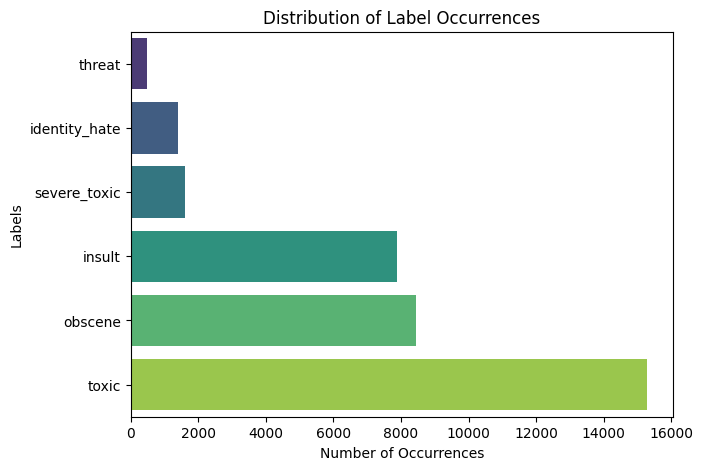

In [16]:
# Visualizing the class distribution of the 'label' column
column_labels = data.columns.tolist()[2:]
label_counts = data[column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()


In [17]:
data[column_labels].sum().sort_values()


,0
threat,478
identity_hate,1405
severe_toxic,1595
insult,7877
obscene,8449
toxic,15294


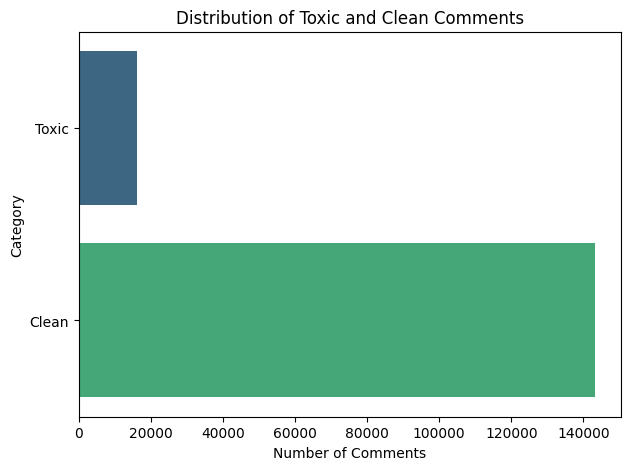

In [18]:
# Create subsets based on toxic and clean comments
train_toxic = data[data[column_labels].sum(axis=1) > 0]
train_clean = data[data[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame(
	{'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

# Set ticks' color to white
ax.tick_params()

# Show the plot
plt.show()


In [19]:
print(train_toxic.shape)
print(train_clean.shape)


(16225, 8)
(143346, 8)


In [20]:
#Randomly sample 15,000 clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and sampled clean comments
dataframe = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
dataframe = dataframe.sample(frac=1, random_state=42) # Changed df to dataframe

In [21]:
print(train_toxic.shape)
print(train_clean_sampled.shape)
print(dataframe.shape)


(16225, 8)
(16225, 8)
(32450, 8)


In [22]:
# Split data into training, testing sets & validation sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
	dataframe['comment_text'], dataframe.iloc[:, 2:], test_size=0.25, random_state=42)


In [23]:
# validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
	test_texts, test_labels, test_size=0.5, random_state=42)

In [24]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
	# Initialize empty lists to store tokenized inputs and attention masks
	input_ids = []
	attention_masks = []

	# Iterate through each comment in the 'comments' list
	for comment in comments:

		# Tokenize and encode the comment using the BERT tokenizer
		encoded_dict = tokenizer.encode_plus(
			comment,

			# Add special tokens like [CLS] and [SEP]
			add_special_tokens=True,

			# Truncate or pad the comment to 'max_length'
			max_length=max_length,

			# Pad the comment to 'max_length' with zeros if needed
			pad_to_max_length=True,

			# Return attention mask to mask padded tokens
			return_attention_mask=True,

			# Return PyTorch tensors
			return_tensors='pt'
		)

		# Append the tokenized input and attention mask to their respective lists
		input_ids.append(encoded_dict['input_ids'])
		attention_masks.append(encoded_dict['attention_mask'])

	# Concatenate the tokenized inputs and attention masks into tensors
	input_ids = torch.cat(input_ids, dim=0)
	attention_masks = torch.cat(attention_masks, dim=0)

	# Convert the labels to a PyTorch tensor with the data type float32
	labels = torch.tensor(labels, dtype=torch.float32)

	# Return the tokenized inputs, attention masks, and labels as PyTorch tensors
	return input_ids, attention_masks, labels


In [25]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
										do_lower_case=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [26]:
# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
													num_labels=6)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# Move model to GPU if available
device = torch.device(
	'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)


In [27]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
	tokenizer,
	train_texts,
	train_labels.values
)

# Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
	tokenizer,
	test_texts,
	test_labels.values
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
	tokenizer,
	val_texts,
	val_labels.values
)


print('Training Comments :',train_texts.shape)
print('Input Ids		 :',input_ids.shape)
print('Attention Mask :',attention_masks.shape)
print('Labels		 :',labels.shape)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Comments : (24337,)
Input Ids		 : torch.Size([24337, 128])
Attention Mask : torch.Size([24337, 128])
Labels		 : torch.Size([24337, 6])


In [29]:
k = 53
print('Training Comments -->>',train_texts.values[k])
print('\nInput Ids -->>\n',input_ids[k])
print('\nDecoded Ids -->>\n',tokenizer.decode(input_ids[k]))
print('\nAttention Mask -->>\n',attention_masks[k])
print('\nLabels -->>',labels[k])


Training Comments -->> They did and have done, on my talk page and on their talk page and most the time im not really doing anything and i always seem to get the finger pointed at me. So what do you expect me to do if someone is uncivil towards me?

Input Ids -->>
 tensor([  101,  2027,  2106,  1998,  2031,  2589,  1010,  2006,  2026,  2831,
         3931,  1998,  2006,  2037,  2831,  3931,  1998,  2087,  1996,  2051,
        10047,  2025,  2428,  2725,  2505,  1998,  1045,  2467,  4025,  2000,
         2131,  1996,  4344,  4197,  2012,  2033,  1012,  2061,  2054,  2079,
         2017,  5987,  2033,  2000,  2079,  2065,  2619,  2003,  4895,  6895,
        14762,  2875,  2033,  1029,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    

In [30]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# testing set
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# validation set
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [31]:
print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])


Batch Size : 32
Each Input ids shape : torch.Size([32, 128])
Input ids :
 tensor([  101,  2054,  2027,  2360,  2055, 16948,  2003,  2157,  1012,  2009,
         1005,  1055,  1037, 11240,  5177,  3012,  1012,  1045,  2123,  1005,
         1056,  2507,  1037,  4485,  2055,  2115,  3513,  1012,  1045,  2079,
         2054,  2003,  2157,  1012,  2054,  2003,  2157,  2003,  2437,  1996,
        10086,  2015,  2008,  6149,  1999,  7011,  6593,  8787,  2592,  1012,
         2017,  2123,  1005,  1056,  2228,  1045,  1005,  1049, 15123,  1999,
         2893,  9421,  2125,  2138,  2070, 12181,  2921,  7065,  8743,  2075,
         2531,  1003,  9398, 10086,  2015,  1029,  5667, 16948,  1010,  2017,
         2024,  2440,  1997,  4426,  1012,  3802,  7413,  4674,  1029,  3905,
         1012,  3078,  3125,  2003,  2000,  2131,  4790,  2157,  1998,  1045,
         2106,  2008,  1012,  2017,  2024, 28781,  2005, 10851,  2033,  2021,
         2025, 10851,  1996,  3559,  2040,  2921,  7065,  8743,  207

In [32]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=2e-5)


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_scheduler
)
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT model with dropout
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
).to(device)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Dummy dataset (Replace with real data)
texts = ["This is a positive review!", "This is a negative review!", "Amazing product!", "Worst ever."]
labels = [1, 0, 1, 0]

# Split dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

# Tokenization function
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        encodings = encode_texts(texts, tokenizer)
        self.input_ids = encodings["input_ids"]
        self.attention_mask = encodings["attention_mask"]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.labels[idx]

# Create train and validation datasets
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1, verbose=True)

# Gradient Scaler for mixed precision training
scaler = GradScaler()

# Training Function
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs=5, accumulation_steps=2):
    best_val_loss = float("inf")
    patience = 2
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_loader):
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss / accumulation_steps  # Normalize loss for accumulation

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:  # Update weights less frequently
                scaler.step(optimizer)
                scaler.update()

            total_loss += loss.item()

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]
                with autocast():
                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    val_loss += outputs.loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1} | Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

        # Reduce LR if no improvement
        scheduler.step(avg_val_loss)

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered! Training stopped.")
                break

# Train the model
train_model(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs=5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-c0589b23391b>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-32-c0589b23391b>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-32-c0589b23391b>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Training Loss: 0.2985 | Validation Loss: 0.5796
Epoch 2 | Training Loss: 0.3811 | Validation Loss: 0.5796
Epoch 3 | Training Loss: 0.3471 | Validation Loss: 0.5796
Early stopping triggered! Training stopped.


In [37]:
# Save the tokenizer and model in the same directory
output_dir = "Saved_model"
# Save model's state dictionary and configuration
model.save_pretrained(output_dir)
# Save tokenizer's configuration and vocabulary
tokenizer.save_pretrained(output_dir)


('Saved_model/tokenizer_config.json',
 'Saved_model/special_tokens_map.json',
 'Saved_model/vocab.txt',
 'Saved_model/added_tokens.json',
 'Saved_model/tokenizer.json')

In [38]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the tokenizer and model from the saved directory
model_name = "Saved_model"

# Load the tokenizer and model correctly
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(model_name).to(device)


In [39]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device):
	user_input = [input_text]

	user_encodings = tokenizer(
		user_input, truncation=True, padding=True, return_tensors="pt")

	user_dataset = TensorDataset(
		user_encodings['input_ids'], user_encodings['attention_mask'])

	user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

	model.eval()
	with torch.no_grad():
		for batch in user_loader:
			input_ids, attention_mask = [t.to(device) for t in batch]
			outputs = model(input_ids, attention_mask=attention_mask)
			logits = outputs.logits
			predictions = torch.sigmoid(logits)

	predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
	labels_list = ['toxic', 'severe_toxic', 'obscene',
				'threat', 'insult', 'identity_hate']
	result = dict(zip(labels_list, predicted_labels[0]))
	return result


text = 'Are you insane!'
predict_user_input(input_text=text)


{'toxic': np.int64(1), 'severe_toxic': np.int64(0)}

In [41]:
text = "Such an Idiot person"
predict_user_input(model=Bert_Model,
				tokenizer=Bert_Tokenizer,
				input_text=text,
				device=device)


{'toxic': np.int64(1), 'severe_toxic': np.int64(0)}

In [42]:
text = "bitch"
predict_user_input(model=Bert_Model,
				tokenizer=Bert_Tokenizer,
				input_text=text,
				device=device)

{'toxic': np.int64(1), 'severe_toxic': np.int64(0)}

In [43]:
text = "fuck your"
predict_user_input(model=Bert_Model,
				tokenizer=Bert_Tokenizer,
				input_text=text,
				device=device)

{'toxic': np.int64(1), 'severe_toxic': np.int64(0)}

In [44]:
pip install streamlit transformers torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6